<a href="https://colab.research.google.com/github/sn0rkmaiden/rnn-practice/blob/main/Vanilla_character_base_LSTM_for_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import unidecode
import string
import random
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def sigmoid(x):
    """Numerically stable version of the logistic sigmoid function"""
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [63]:
all_characters = string.printable
n_characters = len(all_characters)

# file_path="/content/drive/MyDrive/shakespeare.txt"
# file_path="/content/drive/MyDrive/alice_in_wonderland.txt"
file_path="/content/drive/MyDrive/cpp.txt"

data = unidecode.unidecode(open(file_path).read())
vocab_size = len(data)
print('file_len =', vocab_size)

file_len = 808920


In [64]:
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
data_size, vocab_size

(808920, 97)

In [65]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

In [66]:
chunk_len = 200
hidden_size = 100
seq_len = 25

def random_chunk():
    start_index = random.randint(0, data_size - chunk_len)
    end_index = start_index + chunk_len + 1
    return data[start_index:end_index]

print(random_chunk())

	{
	case C_ID_ID:
	  return false;
	case C_ID_ADDRSPACE:
	  return true;
	case C_ID_TYPENAME:
	  return true;
	case C_ID_CLASSNAME:
	  gcc_assert (c_dialect_objc ());
	  return true;
	default:
	  gcc_u


In [67]:
class LSTM(nn.Module):
  def __init__(self, hidden_size, vocab_size):
    super(LSTM, self).__init__()
    self.hidden = np.zeros((hidden_size, 1))

    # self.Wf1 = np.random.randn(hidden_size, vocab_size)
    # self.Wf2 = np.random.randn(hidden_size, hidden_size)
    # self.bf = np.zeros((hidden_size, 1))

    # self.Wi1 = np.random.randn(hidden_size, vocab_size)
    # self.Wi2 = np.random.randn(hidden_size, hidden_size)
    # self.bi = np.zeros((hidden_size, 1))

    # self.Wc1 = np.random.randn(hidden_size, vocab_size)
    # self.Wc2 = np.random.randn(hidden_size, hidden_size)
    # self.bc = np.zeros((hidden_size, 1))

    # self.Wo1 = np.random.randn(hidden_size, vocab_size)
    # self.Wo2 = np.random.randn(hidden_size, hidden_size)
    # self.bo = np.zeros((hidden_size, 1))

    # self.Wy = np.random.randn(vocab_size, hidden_size)
    # self.by = np.zeros((vocab_size, 1))

    # self.Wx = np.random.randn((vocab_size, 4 * hidden_size))
    # self.Wh = np.random.randn((vocab_size, 4 * vocab_size))
    # self.b = np.zeros((vocab_size * 4, 1))

    self.Wf = np.random.randn(hidden_size, hidden_size + vocab_size) * 0.01
    self.bf = np.zeros((hidden_size, 1))
    self.Wi = np.random.randn(hidden_size, hidden_size + vocab_size) * 0.01
    self.bi = np.zeros((hidden_size, 1))
    self.Wcc = np.random.randn(hidden_size, hidden_size + vocab_size) * 0.01
    self.bcc = np.zeros((hidden_size, 1))
    self.Wo = np.random.randn(hidden_size, hidden_size + vocab_size) * 0.01
    self.bo = np.zeros((hidden_size, 1))
    self.Wy = np.random.randn(vocab_size, hidden_size) * 0.01
    self.by = np.zeros((vocab_size, 1))

  def forward(self, x, hprev, cprev):
    # forget = sigmoid(np.dot(self.Wf1, x) + np.dot(self.Wf2, hprev) + self.bf)
    # input = sigmoid(np.dot(self.Wi1, x) + np.dot(self.Wi2, hprev) + self.bi)
    # output = sigmoid(np.dot(self.Wo1, x) + np.dot(self.Wo2, hprev) + self.bo)
    # c_hat = sigmoid(np.dot(self.Wc1, x) + np.dot(self.Wc2, hprev) + self.bc)

    xh = np.vstack((x, hprev))

    forget = sigmoid(np.dot(self.Wf, xh) + self.bf)
    input = sigmoid(np.dot(self.Wi, xh) + self.bi)
    output = sigmoid(np.dot(self.Wo, xh) + self.bo)
    c_hat = np.tanh(np.dot(self.Wcc, xh) + self.bcc)

    next_c = forget * cprev + input * c_hat
    next_h = output * np.tanh(next_c)

    y = np.dot(self.Wy, next_h) + self.by

    return next_h, next_c, y, forget, input, output, c_hat

  def calculate_probs(self, y):
    return np.exp(y) / np.sum(np.exp(y))

  def calc_loss(self, inputs, targets, hprev=None, cprev=None):
    loss = 0
    xs, xhs, ys, ps, hs, cs, fgs, igs, ccs, ogs = (
            {}, {}, {}, {}, {}, {}, {}, {}, {}, {})

    if hprev is not None:
      hs[-1] = np.copy(hprev)

    if cprev is not None:
      cs[-1] = np.copy(cprev)

    for t in range(len(inputs)):
      xs[t] = np.zeros((vocab_size, 1))
      xs[t][inputs[t]] = 1

      xhs[t] = np.vstack((xs[t], hs[t-1]))

      hs[t], cs[t], ys[t], fgs[t], igs[t], ogs[t], ccs[t] = self.forward(xs[t], hs[t-1], cs[t-1])
      ps[t] = self.calculate_probs(ys[t])

      loss += -np.log(ps[t][targets[t], 0])

    return loss, hs[len(inputs)-1], cs[len(inputs)-1], xs, xhs, hs, cs, ps, fgs, igs, ogs, ccs

  def backward(self, inputs, targets, xs, xhs, hs, ps, cs, fgs, igs, ogs, ccs):
    dWf = np.zeros((hidden_size, hidden_size + vocab_size))
    dbf = np.zeros_like(self.bf)
    dWi = np.zeros((hidden_size, hidden_size + vocab_size))
    dbi = np.zeros_like(self.bi)
    dWcc = np.zeros((hidden_size, hidden_size + vocab_size))
    dbcc = np.zeros_like(self.bcc)
    dWo = np.zeros((hidden_size, hidden_size + vocab_size))
    dbo = np.zeros_like(self.bo)
    dWy = np.zeros_like(self.Wy)
    dby = np.zeros_like(self.by)

    dhnext = np.zeros_like(hs[0])
    dcnext = np.zeros_like(cs[0])

    for t in reversed(range(len(inputs))):
      # Backprop through the gradients of loss and softmax.
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1

        # Compute gradients for the Wy and by parameters.
        dWy += np.dot(dy, hs[t].T)
        dby += dy

        # Backprop through the fully-connected layer (Wy, by) to h. Also add up
        # the incoming gradient for h from the next cell.
        dh = np.dot(self.Wy.T, dy) + dhnext

        # Backprop through multiplication with output gate; here "dtanh" means
        # the gradient at the output of tanh.
        dctanh = ogs[t] * dh
        # Backprop through the tanh function; since cs[t] branches in two
        # directions we add dcnext too.
        dc = dctanh * (1 - np.tanh(cs[t]) ** 2) + dcnext

        # Backprop through multiplication with the tanh; here "dhogs" means
        # the gradient at the output of the sigmoid of the output gate. Then
        # backprop through the sigmoid itself (ogs[t] is the sigmoid output).
        dhogs = dh * np.tanh(cs[t])
        dho = dhogs * ogs[t] * (1 - ogs[t])

        # Compute gradients for the output gate parameters.
        dWo += np.dot(dho, xhs[t].T)
        dbo += dho

        # Backprop dho to the xh input.
        dxh_from_o = np.dot(self.Wo.T, dho)

        # Backprop through the forget gate: sigmoid and elementwise mul.
        dhf = cs[t-1] * dc * fgs[t] * (1 - fgs[t])
        dWf += np.dot(dhf, xhs[t].T)
        dbf += dhf
        dxh_from_f = np.dot(self.Wf.T, dhf)

        # Backprop through the input gate: sigmoid and elementwise mul.
        dhi = ccs[t] * dc * igs[t] * (1 - igs[t])
        dWi += np.dot(dhi, xhs[t].T)
        dbi += dhi
        dxh_from_i = np.dot(self.Wi.T, dhi)

        dhcc = igs[t] * dc * (1 - ccs[t] ** 2)
        dWcc += np.dot(dhcc, xhs[t].T)
        dbcc += dhcc
        dxh_from_cc = np.dot(self.Wcc.T, dhcc)

        # Combine all contributions to dxh, and extract the gradient for the
        # h part to propagate backwards as dhnext.
        dxh = dxh_from_o + dxh_from_f + dxh_from_i + dxh_from_cc
        dhnext = dxh[vocab_size:, :]

        # dcnext from dc and the forget gate.
        dcnext = fgs[t] * dc

    # Gradient clipping to the range [-5, 5].
    for dparam in [dWf, dbf, dWi, dbi, dWcc, dbcc, dWo, dbo, dWy, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return dWf, dbf, dWi, dbi, dWcc, dbcc, dWo, dbo, dWy, dby

In [68]:
model = LSTM(hidden_size, vocab_size)

In [69]:
input = np.zeros((vocab_size, 1))
h = np.random.randn(hidden_size, 1)
c = np.random.randn(hidden_size, 1)

print(input.shape, h.shape, c.shape)

next_h, next_c, y, forget, input, output, c_hat = model.forward(input, h, c)
next_h.shape, next_c.shape, y.shape

(97, 1) (100, 1) (100, 1)


((100, 1), (100, 1), (97, 1))

In [76]:
n, p = 0, 0
epochs = 5000 * 2
learning_rate = 1e-1
smooth_loss = -np.log(1.0 / vocab_size) * seq_len # loss at iteration 0

losses = []

# memory variables for Adagrad
mWf, mWi, mWo, mWc, mWy = np.zeros_like(model.Wf), np.zeros_like(model.Wi), np.zeros_like(model.Wo), np.zeros_like(model.Wcc), np.zeros_like(model.Wy)
mbf, mbi, mbo, mbc, mby = np.zeros_like(model.bf), np.zeros_like(model.bi), np.zeros_like(model.bo), np.zeros_like(model.bcc), np.zeros_like(model.by)

for i in range(epochs):

  if p + seq_len + 1 >= len(data) or i == 0:
    hprev = np.zeros((hidden_size, 1)) # reset RNN memory
    cprev = np.zeros((hidden_size, 1))
    p = 0 # go from start of data

  inputs = [char_to_ix[ch] for ch in data[p:p + seq_len]]
  targets = [char_to_ix[ch] for ch in data[p + 1 : p + seq_len + 1]]

  loss, hprev, cprev, xs, xhs, hs, cs, ps, fgs, igs, ogs, ccs = model.calc_loss(inputs, targets, hprev, cprev)
  dWf, dbf, dWi, dbi, dWcc, dbcc, dWo, dbo, dWy, dby = model.backward(inputs, targets, xs, xhs, hs, ps, cs, fgs, igs, ogs, ccs)
  # print(loss)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if i % 500 == 0:
    print('iter %d, loss: %f' % (i, smooth_loss)) # print progress
    losses.append(smooth_loss)
  # if i % 1000 == 0: print('iter %d' % i) # print progress

  for param, dparam, mem in zip([model.Wf, model.Wi, model.Wo, model.Wcc, model.Wy, model.bf, model.bi, model.bo, model.bcc, model.by],
                                [dWf, dWi, dWo, dWcc, dWy, dbf, dbi, dbo, dbcc, dby],
                                [mWf, mWi, mWo, mWc, mWy, mbf, mbi, mbo, mbc, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_len

iter 0, loss: 114.294668
iter 500, loss: 87.171812
iter 1000, loss: 64.273413
iter 1500, loss: 52.422641
iter 2000, loss: 43.803652
iter 2500, loss: 37.661938
iter 3000, loss: 36.470085
iter 3500, loss: 32.566457
iter 4000, loss: 31.829932
iter 4500, loss: 30.927084
iter 5000, loss: 28.977739
iter 5500, loss: 27.007729
iter 6000, loss: 26.968245
iter 6500, loss: 24.885138
iter 7000, loss: 24.378895
iter 7500, loss: 24.199810
iter 8000, loss: 25.313021
iter 8500, loss: 28.877450
iter 9000, loss: 28.243340
iter 9500, loss: 26.135400


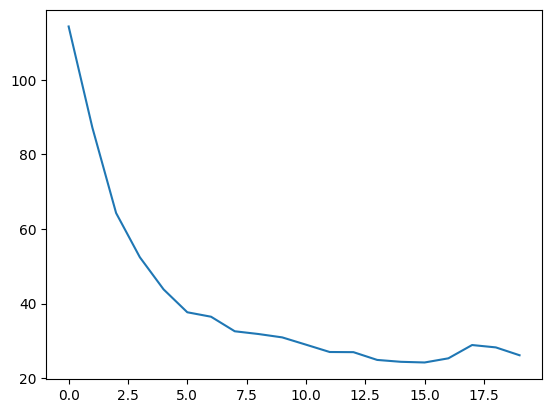

In [77]:
plt.plot(losses)
plt.show()

In [78]:
def sample_chars(hidden_state, cell_state, seed_idx, num_seq):
      """Sample a sequence of characters from the current model, this is primarily used for test time"""
      x = np.zeros((vocab_size, 1))
      x[seed_idx] = 1
      indices = []
      for _ in range(num_seq):
          next_h, next_c, y, forget, input, output, c_hat = model(x, hidden_state, cell_state)
          prob = model.calculate_probs(y)
          idx = np.random.choice(range(vocab_size), p=prob.ravel())  # ravel() flattens the matrix
          x = np.zeros((vocab_size, 1))
          x[idx] = 1
          indices.append(idx)

      return hidden_state, indices

In [85]:
letter = '-'
hidden_state = np.zeros((hidden_size, 1))
cell_state = np.zeros((hidden_size, 1))
_, sampled_indices = sample_chars(hprev, cprev, char_to_ix[letter], 500)
predicted_text = ''.join(ix_to_char[idx] for idx in sampled_indices)
print("-------------\n%s\n-------------" % predicted_text)

-------------
biopediocioco
	-a'temeated-igusize-at, %<t agu
 ifio
 ioumedebed-sivaum-it %%")
 at idaubioro Otitedio_te_(-bio_o n diorured ted%%_iotint-aut, oiiotio io
 %o
 teeno atredaut_o teme
 e3 p_bute, agedio te auifivo u%usio_sum-s), wi")
 ay at%-u se_tes tagute, o bicop_tedifiooibe
 ted dagu_ iouze, te" ag. afioum-atio
	 teduau io_owaly"), h-diooiS. = aninioprifior-s, t msiage %] Obed_o bio
,
 ioulio fio", tio (, ifiou
{-lio_oriteme (sime. (dio
 afifio
 it%> = tiotrenum-ate anoly_at:
	%<iomu wiibio_ola
-------------
